# 5장 웹 API 서비스

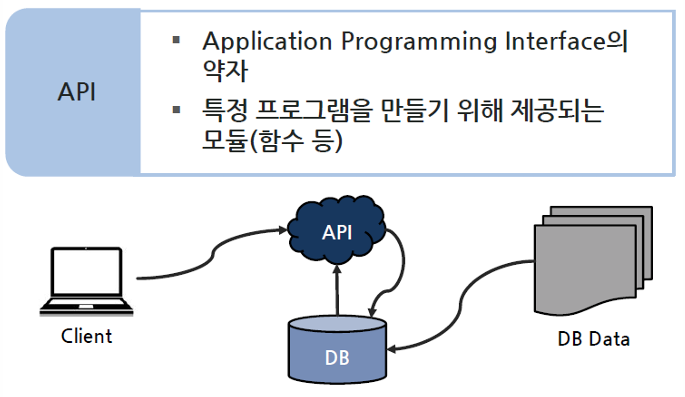

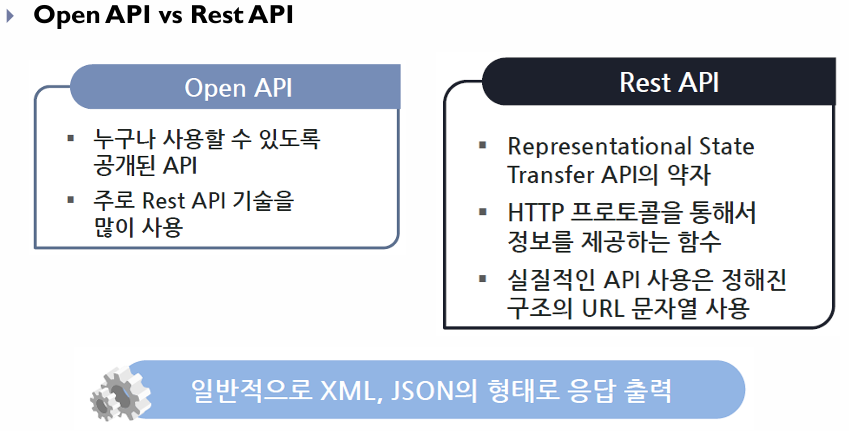

Rest 는 값을 바로 주고 받음.

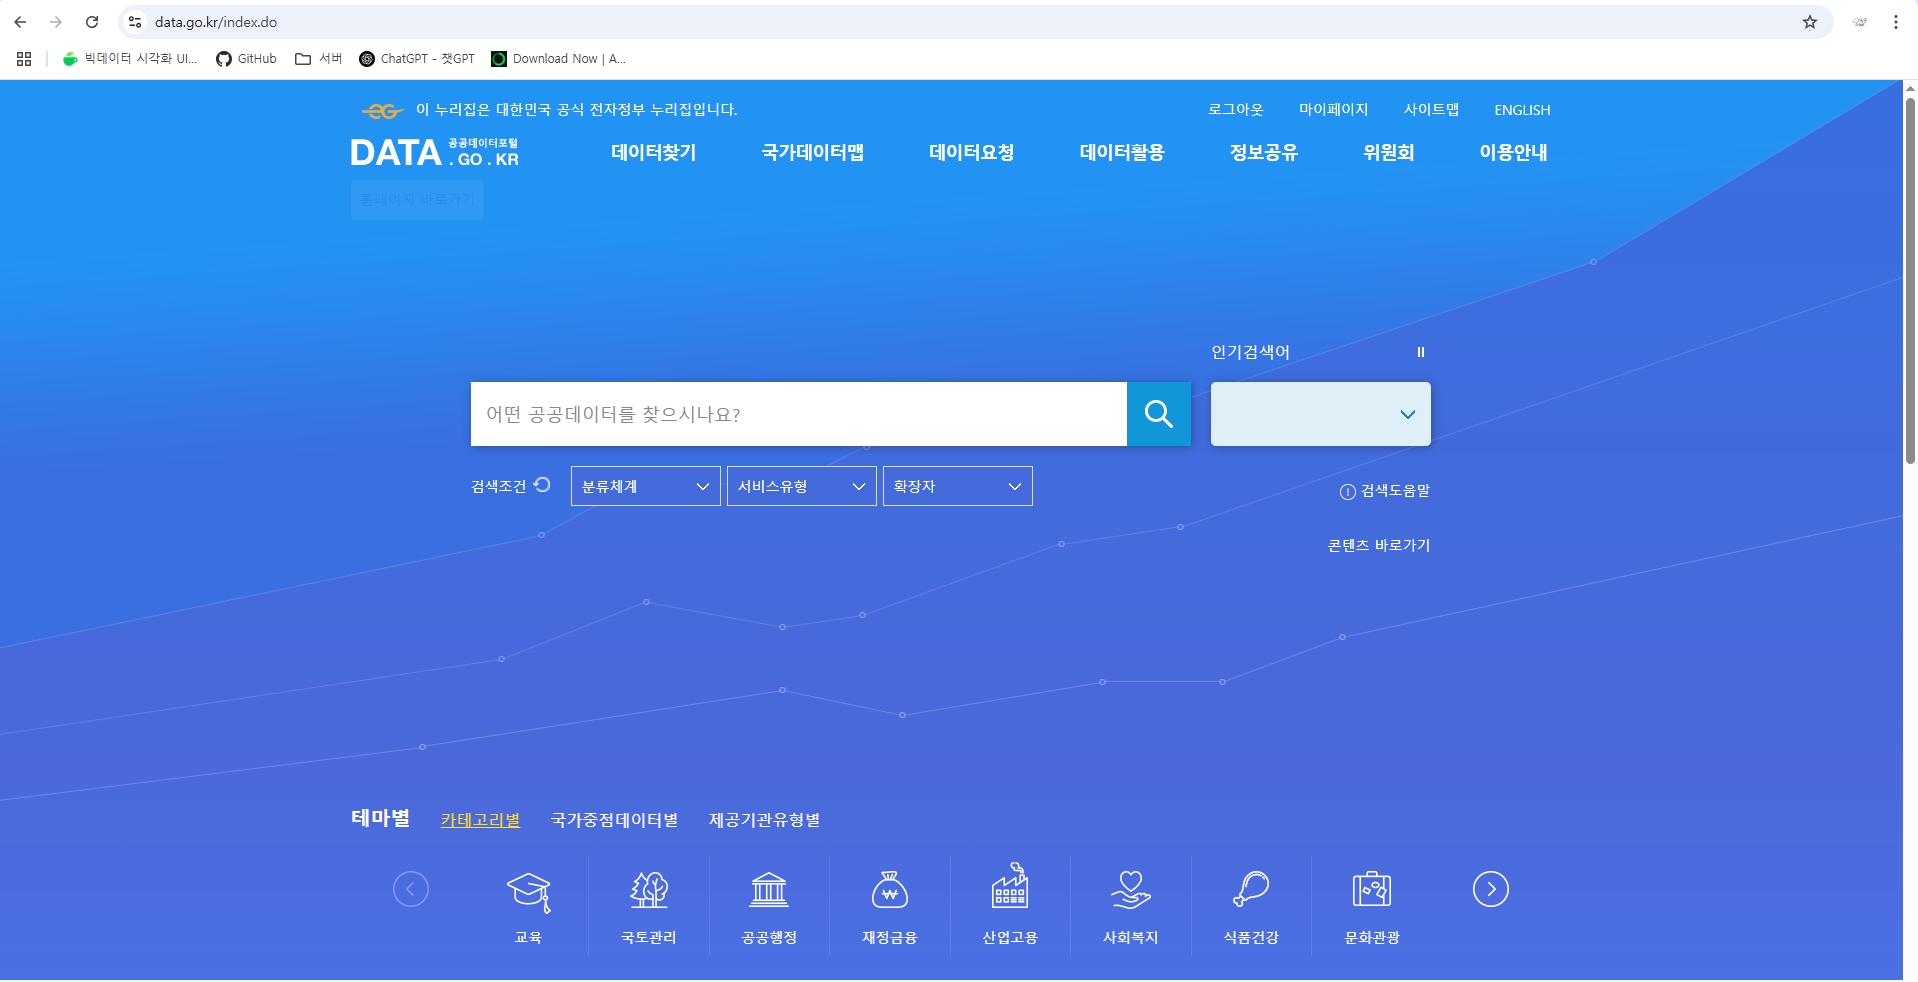

공공데이터 서비스에 접속(https://www.data.go.kr)  
로그인 및 원하는 주제의 오픈API를 신청해두자

- xml파일로 받아와서 자료 처리

In [2]:
import urllib.request as req
import re
from bs4 import BeautifulSoup as bs
import pandas as pd
import pymysql

In [4]:
key = 'xAMz6gggHdVtkbU0OHvjZoJFFNaZPM6kvynoNtOY1b4HJXe1bUN5TpUNNvKf5zm7c2N6sJVreVxLVXnPQlTXeg%3D%3D'
url = 'http://apis.data.go.kr/6260000/FestivalService/getFestivalKr'
prams = f'?ServiceKey={key}&pageN0=1&numOfRows=10'

save_path ='data/festival.xml'
req.urlretrieve(url+prams, save_path)

('data/festival.xml', <http.client.HTTPMessage at 0x23a304dd250>)

In [5]:
res=req.urlopen(url+prams)
print(res.read().decode('utf-8'))

<?xml version="1.0" encoding="UTF-8"?><response>
  <header>
    <resultCode>00</resultCode>
    <resultMsg>NORMAL_CODE</resultMsg>
  </header>
  <body>
    <items>
      <item>
        <MAIN_TITLE>부산바다축제(한,영, 중간,중번,일)</MAIN_TITLE>
        <LNG>129.11713</LNG>
        <MIDDLE_SIZE_RM1>장애인 한바다축제 수어통역 / (사)부산장애인총연합회 051-863-0650</MIDDLE_SIZE_RM1>
        <UC_SEQ>71</UC_SEQ>
        <USAGE_AMOUNT/>
        <CNTCT_TEL>051-713-5000</CNTCT_TEL>
        <MAIN_IMG_NORMAL>https://www.visitbusan.net/uploadImgs/files/cntnts/20191213191711585_ttiel</MAIN_IMG_NORMAL>
        <TRFC_INFO>도시철도 1호선 다대포해수욕장역 2번 출구 도보 8분
버스 11, 2, 3, 338, 96, 96-1, 1000 </TRFC_INFO>
        <ITEMCNTNTS>
타오르는 태양, 시원한 바다, 금빛 백사장, 화려한 네온사인, 신나는 음악!
이 모든 것을 한 번에 즐길 수 있는 부산의 대표 여름축제, 부산바다축제를 소개한다.
부산바다축제는 해마다 여름이 되면 부산 시내  해수욕장에서 열린다.
축제는 다양한 프로그램으로 사람들을 맞이하는데 그 중에서도 메인 행사는 첫날의 개막파티이다.
매해 새로운 모습을 추구하기에 지난 회차와는 또 다른 행사를 즐길 수 있다.



개막파티를 놓친 이들이라도 매일 새롭게 열리는 참여행사를 통해 축제를 즐길 수 있다.
부산바다축제는 음악, 춤, 먹거리 등 모든 것을 즐길 수 있다.

특히나 뜨거운 여름밤을

In [6]:
xml_doc = open(save_path, 'r', encoding='utf-8')
soup = bs(xml_doc,'xml')
items = soup.find_all('item') 
print(len(items))

def save_img(title, src):
    pattern = r'[가-힣a-zA-Z0-9]+'  # 한글, 영문 대소문자, 숫자 포함
    result = re.findall(pattern, title)
    result=' '.join(result)
    path=f'data/festival_images/%s.jpg'%result
    req.urlretrieve(src,path)

item_list = []

for item in items:
    title=item.find('TITLE').text
    adress = item.find('ADDR1').text
    trfc_info = item.find('TRFC_INFO').text
    usage_day_week_and_time = item.find('USAGE_DAY_WEEK_AND_TIME').text
    main_place = item.find('MAIN_PLACE').text
    homepage_url = item.find('HOMEPAGE_URL').text
    MAIN_IMG_src = item.find('MAIN_IMG_NORMAL').text

    item_list.append((title, adress, trfc_info, usage_day_week_and_time, main_place, homepage_url, MAIN_IMG_src))

    save_img(title,MAIN_IMG_src)

    # 주소, 내용, 교통정보, 축제기간, 축제메인장소, 홈페이지, 이미지 다운 src저장


10


In [7]:
#csv저장
df = pd.DataFrame(item_list, columns=["축제명", "주소", "교통정보", "축제기간", "메인장소", "홈페이지주소", "메인이미지url"])
df.to_csv("data/부산축제정보.csv", encoding="utf8")

In [ ]:
#DB에 저장
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="1234",
    database="pydb",
    charset="utf8"
)
c = conn.cursor()
c.executemany(
    "INSERT INTO tbl_festival(title, address, trfc_info, usage_day_week_and_time, main_place, homepage_url, MAIN_IMG_src) VALUES(%s, %s, %s, %s, %s, %s, %s)",
    item_list
)
conn.commit()
conn.close()

- Json타입으로 받아와서 자료처리

In [15]:
url = 'http://apis.data.go.kr/6260000/FestivalService/getFestivalKr'
prams = f'?ServiceKey={key}&pageN0=1&numOfRows=10&resultType=Json'

save_path2 ='data/festival.json'
req.urlretrieve(url+prams, save_path2)

('data/festival.json', <http.client.HTTPMessage at 0x23a304e6870>)

In [ ]:
import json

item_list = []

with open('data/festival.json', 'r', encoding='utf-8') as f:
    data=json.load(f)               # 중요!! Json문서, 파일을 json으로 파싱해줌 : load 안하면 키값으로 바로 데이터 못가져옴
    items = data['getFestivalKr']['item']
    for item in items:
        title = item['TITLE']
        adress = item['ADDR1']
        trfc_info = item['TRFC_INFO']
        usage_day_week_and_time = item['USAGE_DAY_WEEK_AND_TIME']
        main_place = item['MAIN_PLACE']
        homepage_url = item['HOMEPAGE_URL']
        MAIN_IMG_src = item['MAIN_IMG_NORMAL']    

        item_list.append((title, adress, trfc_info, usage_day_week_and_time, main_place, homepage_url, MAIN_IMG_src))
        
        save_img(title,MAIN_IMG_src)

In [15]:
url = 'http://apis.data.go.kr/6260000/FestivalService/getFestivalKr'
prams = f'?ServiceKey={key}&pageN0=1&numOfRows=10&resultType=Json'

save_path2 ='data/festival.json'
req.urlretrieve(url+prams, save_path2)

('data/festival.json', <http.client.HTTPMessage at 0x236857c0680>)

부산시청 버스정류장 ID  
505780000

29번 버스 라인아이디
5200029000

In [ ]:
#29번 버스 버스id 가져오기
key = 'xAMz6gggHdVtkbU0OHvjZoJFFNaZPM6kvynoNtOY1b4HJXe1bUN5TpUNNvKf5zm7c2N6sJVreVxLVXnPQlTXeg%3D%3D' 
url ='http://apis.data.go.kr/6260000/BusanBIMS/busInfo?'
no = 29
params=f'serviceKey={key}&lineno={no}'
path ='data/businfo.xml'
req.urlretrieve(url+params, path)

('data/businfo.xml', <http.client.HTTPMessage at 0x23a316e1460>)

In [ ]:
xml = open(path, 'r', encoding='utf-8')
soup = bs(xml, 'xml') 
# print(soup)
items = soup.find_all('item') 
# print(items)
lineid=''
for item in items:
    linenum = item.find('buslinenum').text
    # print(linenum)
    if linenum == str(no) :         #linenum은 String이고 no은 int형이라서 두개의 형을 맞춰줘야함.
        lineid = item.find('lineid').text
print(lineid)


5200029000


In [ ]:
#29번 버스 아이디를 이용해서 실시간 버스들위치(정류소명, 위도, 경도)데이터 받아오기
url1='http://apis.data.go.kr/6260000/BusanBIMS/busInfoByRouteId'
params=f'?serviceKey={key}&lineid={lineid}'
save_path = 'data/busposition.xml'
req.urlretrieve(url1+params, save_path)


('data/busposition.xml', <http.client.HTTPMessage at 0x23a31ad5ee0>)

In [42]:
xml = open(save_path, 'r', encoding="utf-8")
soup=bs(xml, 'xml')
items = soup.find_all('item')
# print(items)
for item in items:
    direction= item.find('direction')
    if(direction) : 
        name = item.find('bstopnm').text
        lat = item.find('lat').text
        lin = item.find('lin').text
        print(name, lat, lin)

범어사입구 35.2756512 129.0901632
부산외국어대학교 35.2655680 129.0851328
장전초등학교 35.2399392 129.0864256
부산대역 35.2311072 129.0873088
부산정보관광고 35.2236672 129.0910592
명장조양맨션(명장역) 35.2047008 129.1015040
안락동우체국.동해선안락역 35.1984416 129.0960256
동해선교대역 35.1919360 129.0801664
연산역.연산교차로 35.1881824 129.0811520
부전역 35.1620064 129.0626048
부전시장 35.1580352 129.0594816
안창마을종점 35.1458272 129.0428800
안창마을입구 35.1446752 129.0476672
범내골역3번출구.춘해병원 35.1463616 129.0584960
전포초등학교 35.1595616 129.0623360
동해선교대역 35.1935424 129.0797696
교대역 35.1948704 129.0802432
충렬사역.서원시장 35.2006688 129.0981888
삼성아파트 35.1998976 129.1024512
서동고개 35.2179168 129.0952704
금정세무서 35.2308992 129.0919296
구서역.구서시장 35.2463840 129.0888064
선경3차아파트 35.2582656 129.0877440
범어사입구 35.2755776 129.0921344
부산종합터미널.노포역 35.2882336 129.0964480


In [ ]:
# 정류장에서 버스 도착예정시간 데이터 가져오기
# 시청역 정거장으로

In [44]:
import urllib.parse

stopnm=urllib.parse.quote('부산시청')
url='http://apis.data.go.kr/6260000/BusanBIMS/busStopList?'
params = f'serviceKey={key}&bstopnm={stopnm}'
save_path = 'data/bstop_list.xml' 

res = req.urlretrieve(url+params, save_path)

In [47]:
xml = open(save_path, 'r', encoding='utf-8') 
soup=bs(xml, 'xml')
stopids=[]
for item in soup.find_all('item'):
    stoptype = item.find('stoptype').text
    if stoptype=='일반':
        stopid=item.find('bstopid').text
        stopids.append(stopid)

print(stopids)        

['164720101', '505780000', '505790000']


In [ ]:
url2='http://apis.data.go.kr/6260000/BusanBIMS/busInfo?'
params = f'serviceKey={key}&bstopnm={stopnm}'

In [59]:
url2 ='http://apis.data.go.kr/6260000/BusanBIMS/stopArrByBstopid?'

for stopid in stopids:
    params = f'serviceKey={key}&bstopid={stopid}'

    # 파일로 저장안하고 쓸 때
    xml=req.urlopen(url2+params).read().decode('utf-8')
    # 파일을 저장해서 쓸 때
    # save_path =f'data/busArrStop{stopid}.xml'
    # req.urlretrieve(url2+params, save_path)
    # xml = open(save_path, 'r', encoding='utf-8')
      
    soup=bs(xml, 'xml') 
    items= soup.find_all('item')
    
    nodenm = items[0].find('nodenm').text
    print(f'<{nodenm}정거장 도착예정 정보>')

    for item in items:
        lineno = item.find('lineno').text
        try:
            min1 = item.find('min1').text
        except:
            min1= '-'
        try:
            station1 = item.find('station1').text
        except:
            station1 = '-'
        print(f'{lineno}번 버스 도착예정 {min1}분 후이며, {station1}개 전 정거장에서 오고 있습니다..')


<부산시청.시청역정거장 도착예정 정보>
131번 버스 도착예정 7분 후이며, 4개 전 정거장에서 오고 있습니다..
141번 버스 도착예정 7분 후이며, 4개 전 정거장에서 오고 있습니다..
<부산시청정거장 도착예정 정보>
106번 버스 도착예정 14분 후이며, 4개 전 정거장에서 오고 있습니다..
110-1번 버스 도착예정 8분 후이며, 4개 전 정거장에서 오고 있습니다..
179번 버스 도착예정 4분 후이며, 2개 전 정거장에서 오고 있습니다..
29번 버스 도착예정 16분 후이며, 8개 전 정거장에서 오고 있습니다..
86번 버스 도착예정 12분 후이며, 5개 전 정거장에서 오고 있습니다..
87번 버스 도착예정 6분 후이며, 3개 전 정거장에서 오고 있습니다..
99번 버스 도착예정 7분 후이며, 4개 전 정거장에서 오고 있습니다..
<부산시청정거장 도착예정 정보>
106번 버스 도착예정 14분 후이며, 6개 전 정거장에서 오고 있습니다..
110-1번 버스 도착예정 6분 후이며, 3개 전 정거장에서 오고 있습니다..
131번 버스 도착예정 4분 후이며, 3개 전 정거장에서 오고 있습니다..
141번 버스 도착예정 8분 후이며, 6개 전 정거장에서 오고 있습니다..
179번 버스 도착예정 10분 후이며, 5개 전 정거장에서 오고 있습니다..
29번 버스 도착예정 7분 후이며, 4개 전 정거장에서 오고 있습니다..
86번 버스 도착예정 5분 후이며, 2개 전 정거장에서 오고 있습니다..
87번 버스 도착예정 1분 후이며, 1개 전 정거장에서 오고 있습니다..
99번 버스 도착예정 5분 후이며, 2개 전 정거장에서 오고 있습니다..


<!-- 본인이 정한 정거장에 자신이 지정한 번호의 버스가  -->